In [112]:
# cell 1
%matplotlib inline
import cv2
from PIL import Image
import imutils
import csv
import matplotlib
from plantcv import plantcv as pcv

pcv.params.debug = 'plot'                     # Plot debug images to the notebook

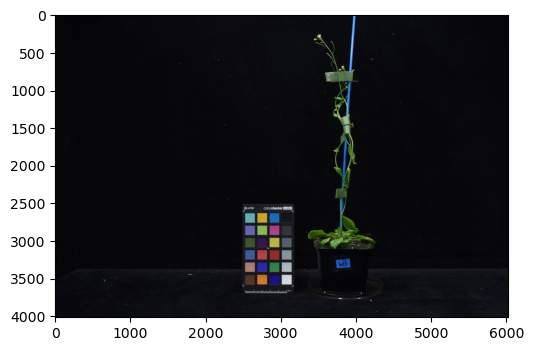

In [113]:
# cell 2
### Main pipeline

# Read target image
img_file = '/data/PhD/Phenotyping/2021-07_Emma/Side/29_8.JPG'
img, path, filename = pcv.readimage(filename = img_file, mode = "rgb")

In [114]:
%%capture
# cell 3
# find colour card in the image to be analysed
df, start, space = pcv.transform.find_color_card(rgb_img = img)
#if int(start[0]) < 2000:
#        img = imutils.rotate_bound(img, -90)
#        rotated = 1
#        df, start, space = pcv.transform.find_color_card(rgb_img = img)
#else: rotated = 0
if img.shape[0] > 6000:
    rotated = 1
else: rotated = 0
img_mask = pcv.transform.create_color_card_mask(rgb_img = img, radius = 10, start_coord = start, spacing = space, ncols = 4, nrows = 6)

In [115]:
rotated

0

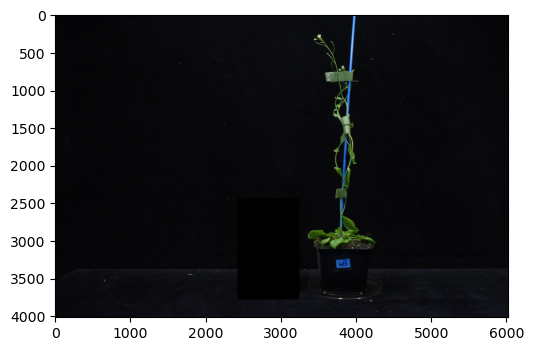

In [116]:
# cell 4
# write the spacing of the colour card to file as size marker   
with open(r'size_marker.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow([filename, space[0]])

# define a bounding rectangle around the colour card
x_cc,y_cc,w_cc,h_cc = cv2.boundingRect(img_mask)
x_cc = int(round(x_cc - 0.3 * w_cc))
y_cc = int(round(y_cc - 0.3 * h_cc))
h_cc = int(round(h_cc * 1.6))
w_cc = int(round(w_cc * 1.6))

# crop out colour card
start_point = (x_cc, y_cc)
end_point = (x_cc+w_cc, y_cc+h_cc)
colour = (0, 0, 0)
thickness = -1
crop_img = cv2.rectangle(img, start_point, end_point, colour, thickness)

pcv.plot_image(crop_img)

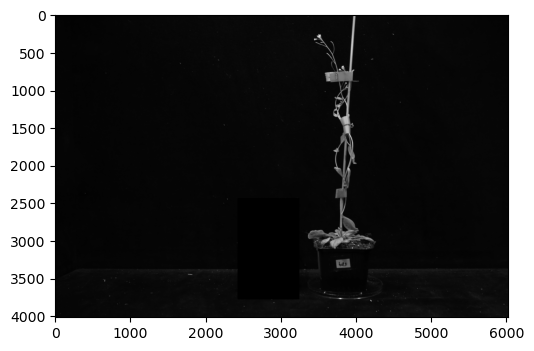

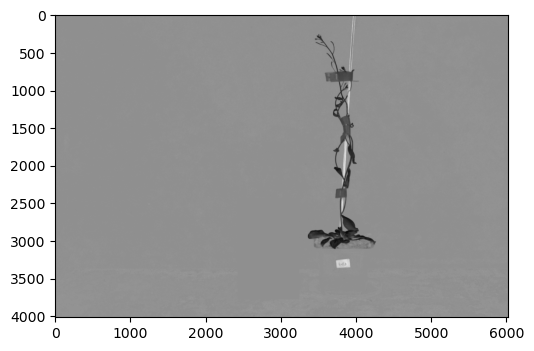

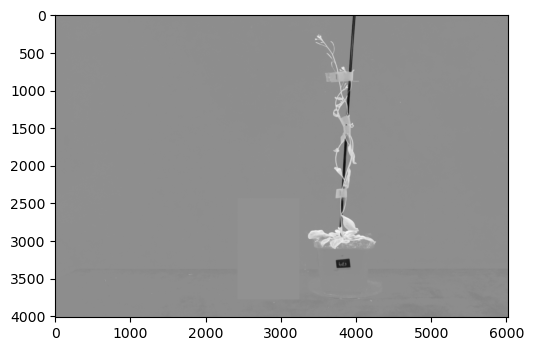

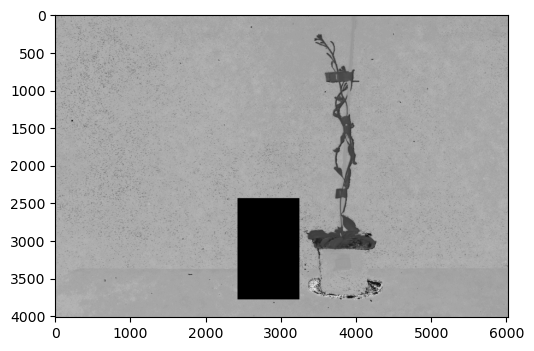

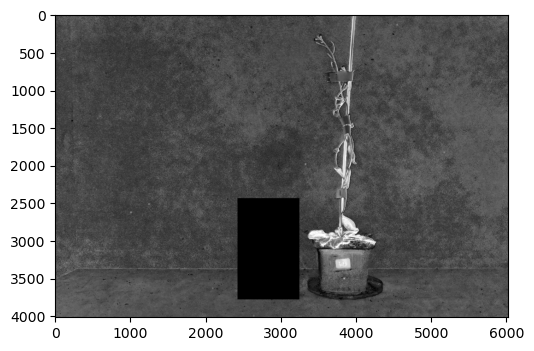

In [117]:
# cell 5
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
l = pcv.rgb2gray_lab(crop_img, "l")
a = pcv.rgb2gray_lab(crop_img, "a")
b = pcv.rgb2gray_lab(crop_img, "b")
h = pcv.rgb2gray_hsv(crop_img, "h")
s = pcv.rgb2gray_hsv(crop_img, "s")

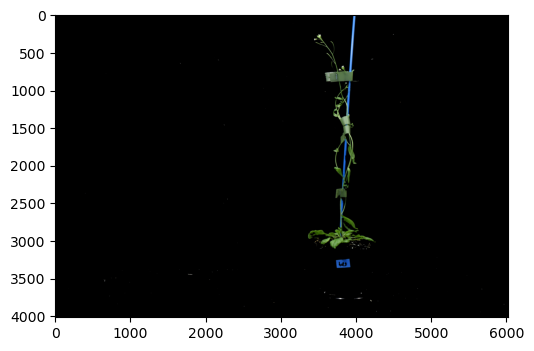

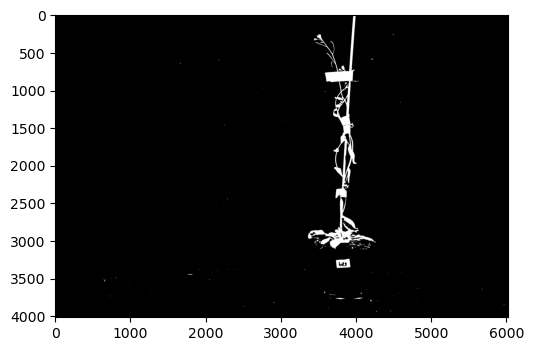

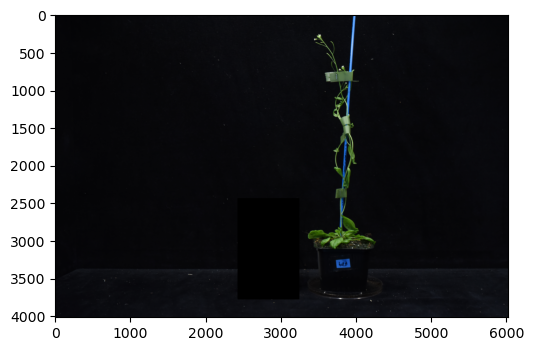

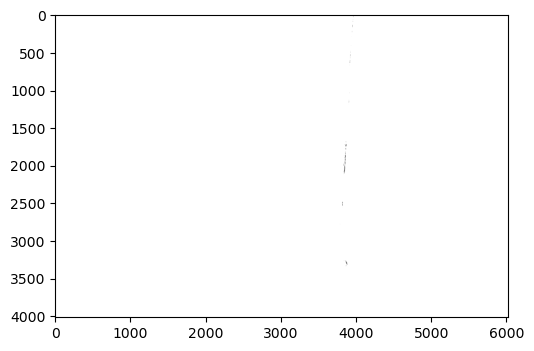

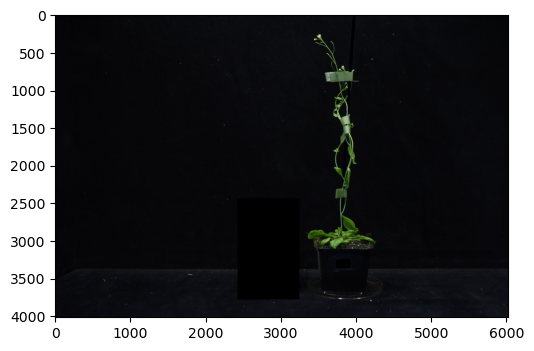

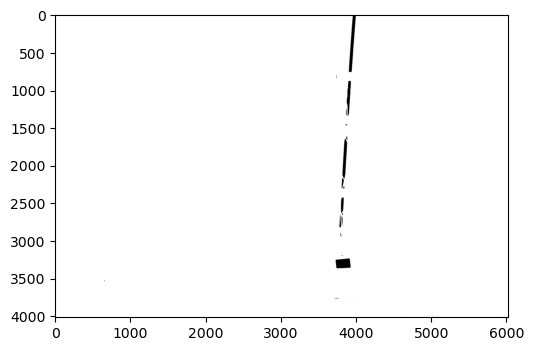

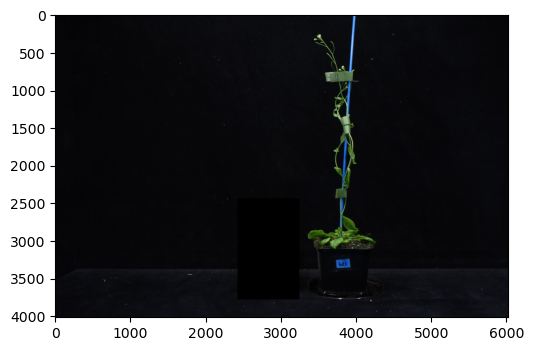

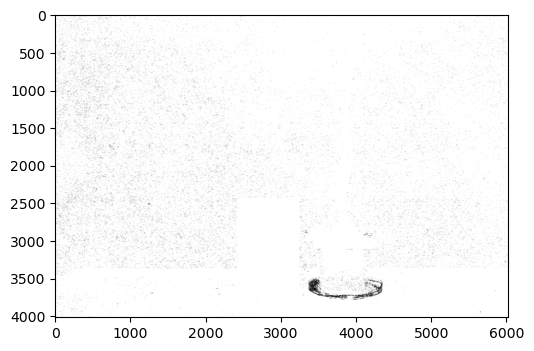

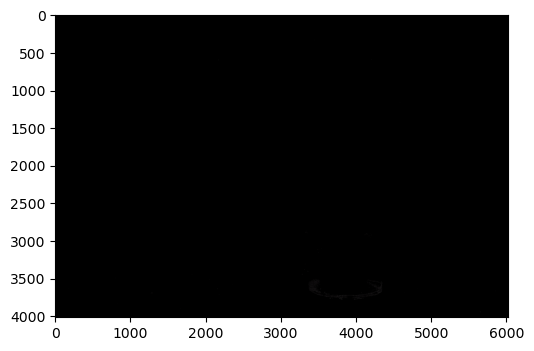

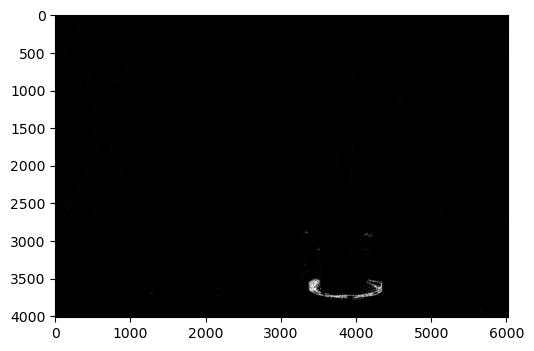

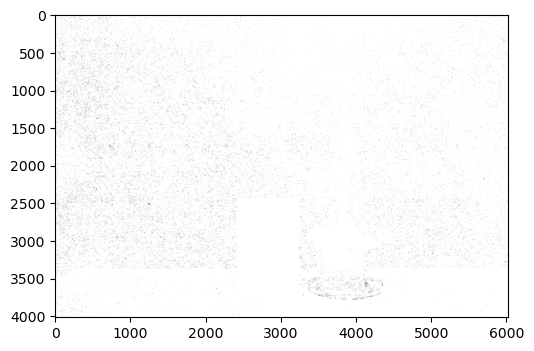

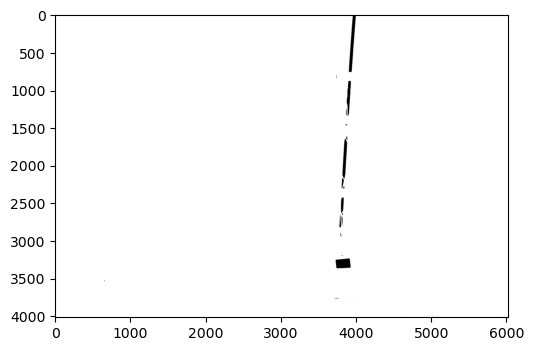

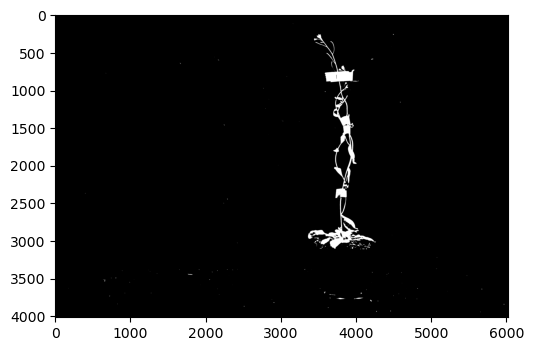

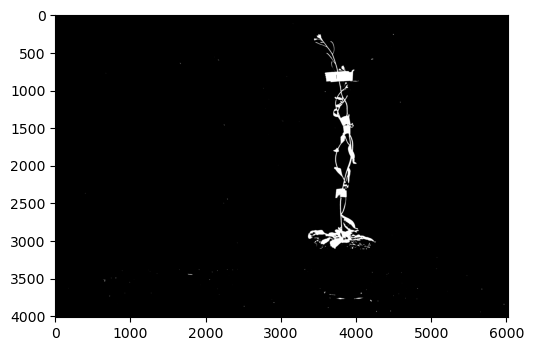

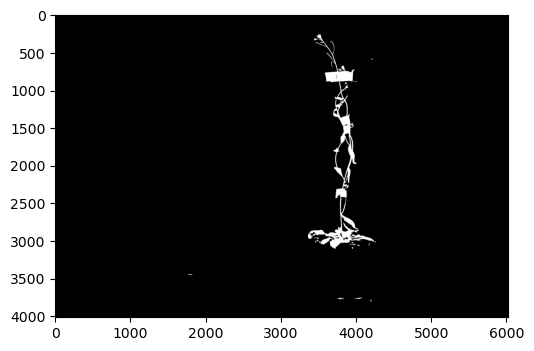

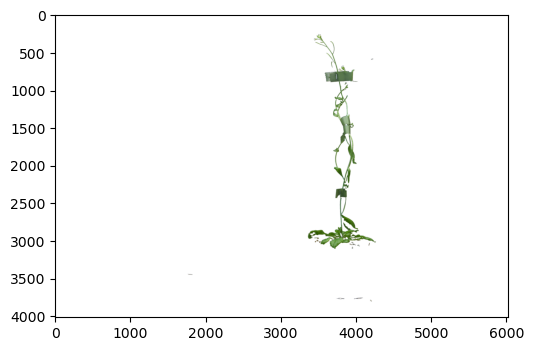

In [118]:
# cell 6
# Threshold A and B channels of the LAB colourspace and the Hue channel of the HSV colourspace
l_thresh, _ = pcv.threshold.custom_range(img=crop_img, lower_thresh=[70,0,0], upper_thresh=[255,255,255], channel='LAB')
a_thresh, _ = pcv.threshold.custom_range(img=crop_img, lower_thresh=[0,0,0], upper_thresh=[255,150,255], channel='LAB')
b_thresh, _ = pcv.threshold.custom_range(img=crop_img, lower_thresh=[0,0,120], upper_thresh=[255,255,255], channel='LAB')
h_thresh_low, _ = pcv.threshold.custom_range(img=crop_img, lower_thresh=[0,0,0], upper_thresh=[130,255,255], channel='HSV')
h_thresh_high, _ = pcv.threshold.custom_range(img=crop_img, lower_thresh=[150,0,0], upper_thresh=[255,255,255], channel='HSV')
h_thresh = pcv.logical_or(h_thresh_low, h_thresh_high)

# Join the thresholded images to keep only consensus pixels
ab = pcv.logical_and(b_thresh, a_thresh)
lab = pcv.logical_and(l_thresh, ab)
labh = pcv.logical_and(lab, h_thresh)

# Fill small objects
labh_clean = pcv.fill(labh, 200)

# Dilate to close broken borders
#labh_dilated = pcv.dilate(labh_clean, 4, 1)
labh_dilated = labh_clean

# Apply mask (for VIS images, mask_color=white)
masked = pcv.apply_mask(crop_img, labh_dilated, "white")

# Detect, dilate to close, and fill edges
#edges = pcv.canny_edge_detect(masked, thickness = 5, sigma = 11)
#edges_dilated = pcv.dilate(edges, 50, 1)
#edges_fill = pcv.fill_holes(edges_dilated)

#abh_fill = pcv.logical_and(abh_fill, edges_fill)

# Apply mask (for VIS images, mask_color=white)
#masked = pcv.apply_mask(crop_img, abh_fill, "white")

pcv.print_image(masked, "dilated.png")

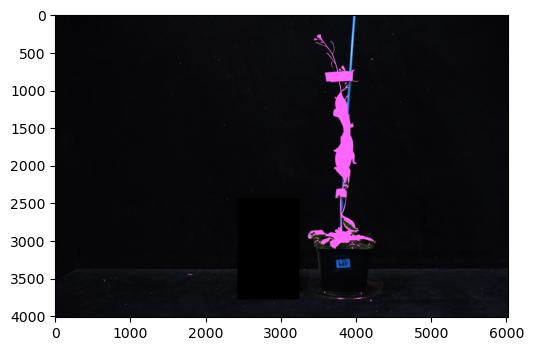

In [119]:
# cell 7
# Identify objects
contours, hierarchy = pcv.find_objects(crop_img, labh_dilated)

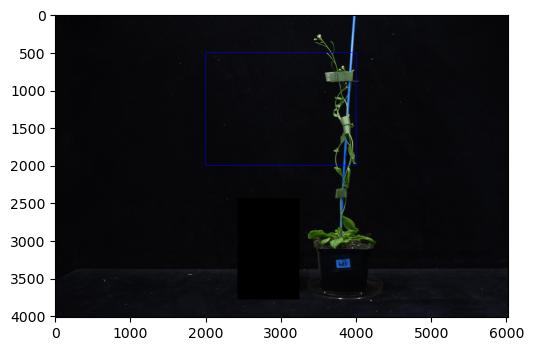

In [120]:
# cell 8
# Define ROI
if rotated == 1:
    roi_contour, roi_hierarchy= pcv.roi.rectangle(x=1000, y=500, h=4000, w=2000, img=crop_img)
else:
    roi_contour, roi_hierarchy= pcv.roi.rectangle(x=2000, y=500, h=1500, w=2000, img=crop_img)

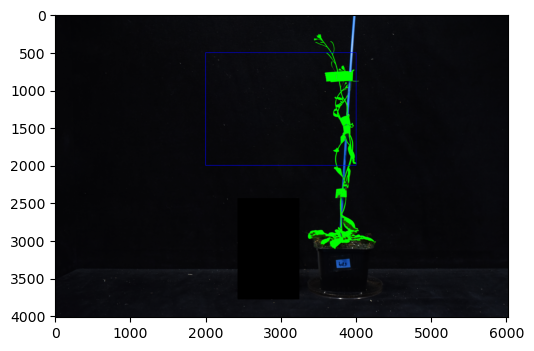

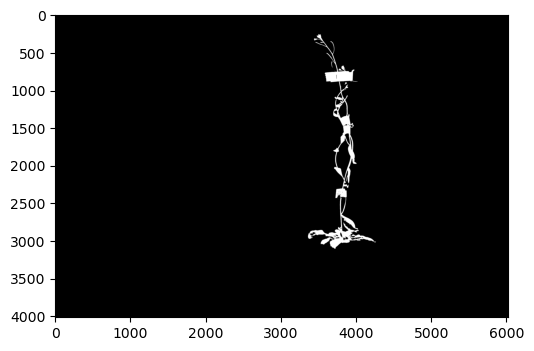

In [121]:
# cell 9
# Decide which objects to keep
filtered_contours, filtered_hierarchy, mask, area = pcv.roi_objects(img = crop_img,
                                                               roi_type = 'partial',
                                                               roi_contour = roi_contour,
                                                               roi_hierarchy = roi_hierarchy,
                                                               object_contour = contours,
                                                               obj_hierarchy = hierarchy)

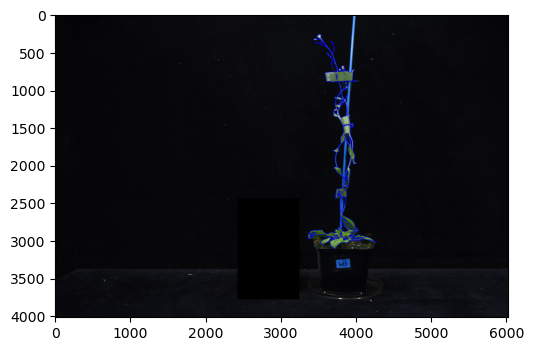

In [122]:
# cell 10
# Object combine kept objects
obj, mask = pcv.object_composition(crop_img, filtered_contours, filtered_hierarchy)

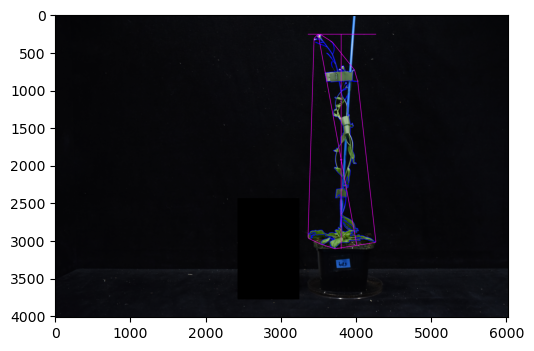

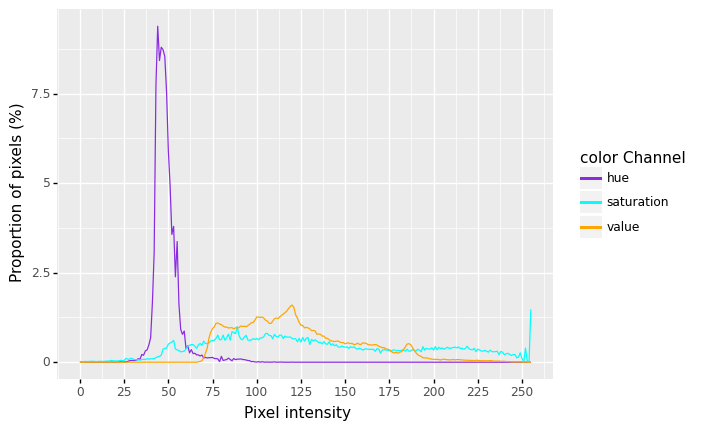

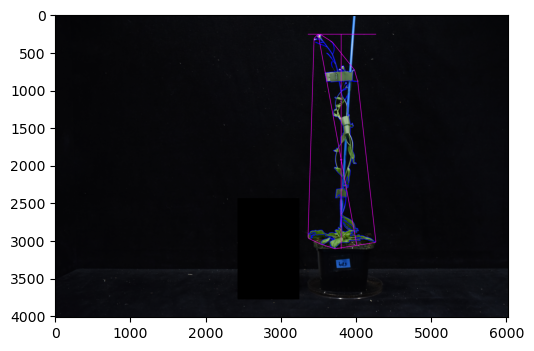

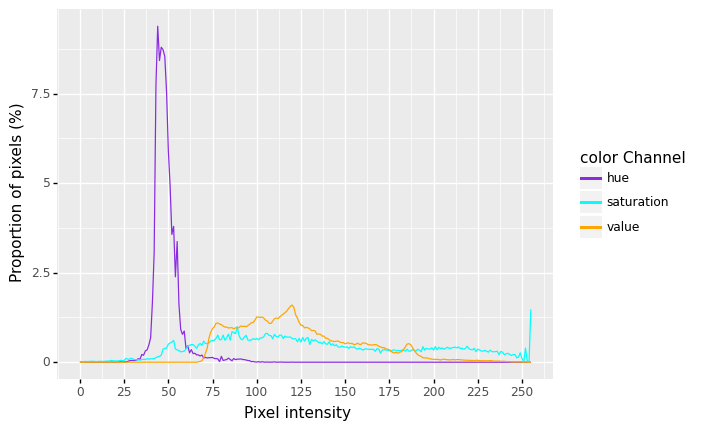

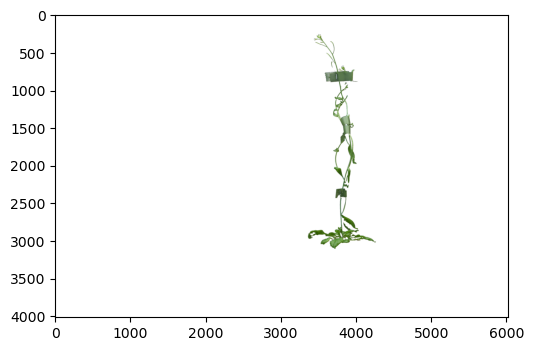

In [123]:
#cell 11
############### Analysis ################

#outfile=False
#if args.writeimg==True:
#    outfile=args.outdir+"/"+filename

# Find shape properties, output shape image (optional)
shape_img = pcv.analyze_object(crop_img, obj, mask)

colour_img = pcv.analyze_color(crop_img, mask, 'hsv')
    
# analysis_images contains two images, the original image with shape data drawn on, and the mask
# Plot them out 
pcv.plot_image(shape_img)
pcv.plot_image(colour_img)
#pcv.plot_image(shape_mask)
pcv.print_image(mask, "final_mask.png")
pcv.print_image(shape_img, "analysed_img.png")
pcv.print_image(colour_img, "colour_img.png")
#pcv.print_image(shape_mask, "mask_2.png")

# keep the segmented plant for visualisation
picture_mask = pcv.apply_mask(img, mask, "white")
pcv.print_image(picture_mask, "outfile.png")
